**Instituto Tecnológico de Costa Rica**  
**Maestría en Electrónica**  
**MP6124. Procesamiento Adaptativo**    
**Profesor:** Juan Pablo Soto Quirós  
**Estudiantes:**  
- Juan Carlos Cruz Naranjo  
- Luis Alonso Murillo Rojas

## Tarea 2

### Problema 1.
Del libro _Fundamentals of Adaptive Filtering_ de Ali Sayed, implemente cada uno de los algoritmos de
gradiente estocástico que se encuentran en la **Tabla 5.1.**, página 230. 

<div style="align: left; text-align:center;">
<img src="tabla5.1.png" style="width:350px;"/>
<figcaption>Tabla 5.1. Algoritmos de Gradiente Estocástico</figcaption>
</div>

Cada uno de los algoritmos de la Tabla 5.1. da una aproximación a la solución del problema de optimización:  

<center>$\underset{w \in \mathbb{C}^{n}}{\text{min}}\mathbb{E}[|\textbf{d-u}w|^{2}]$</center>

donde $\textbf{d}$ es una variable aleatoria, $\textbf{u}$ es un vector fila aleatorio de tamaño _n_ y $w$ es un vector columna constante de tamaño _n_. Para la implementación de cada algoritmo, considere las siguientes indicaciones:
- Cada algoritmo debe ser implementado como una función.
- Los parámetros iniciales de cada función son los siguientes:
 - Observaciones de la variable aleatoria $\textbf{d}$ que se representan en el vector $d=[d_0\text{  }d_1\text{  }...\text{  }d_{s−1}]\in \mathbb{C}^{s}$, donde $d_j \in \mathbb{C}$ es la observación $j$ de $\textbf{d}$.  
 - Observaciones del vector aleatorio $\textbf{u}$, que se representan en la matriz $U= 
\begin{bmatrix} 
u_0 \\
\vdots \\
u_{s-1}
\end{bmatrix} \in \mathbb{C}^{s\times n}$, donde $u_j \in \mathbb{C}^{n}$ es la observación $j$ de $\textbf{u}$.

 - Vector inicial $w^{(−1)} \in \mathbb{C}^m$, el cual es un vector columna.
 - Tolerancia $tol > 0$ para el criterio de parada.
 - Iteraciones máximas $iterMax > 0$.
- Los parámetros finales son el número de iteraciones $k$ y el vector $w^{(k)}$ que aproxima la solución del problema (1).
- Utilice nombres significativos para definir cada una de las funciones.
- El criterio de parada de cada algoritmo será la condición $||w^{(k)} - w^{(k−1)}||_2 < tol$ o cuando el número de iteraciones es mayor a $iterMax$.

- En el método LMS con tamaño de paso variante, puede utilizar como tamaño de paso $\mu_i = \frac{2}{1+i}$ en cada iteración. Si considera oportuno, puede utilizar otro tamaño de paso. De ser así, debe justificar porque seleccionó otro tamaño de paso $\mu_i$.
- Cada método debe generar dos gráficas: una de iteraciones versus error y otra de iteraciones versus valor mínimo. El error se medirá con el criterio $e_k = ||w^{(k)} - w^{(k−1)}||_2$ y el valor mínimo se medirá con el criterio:

<center>$m_k = \hat{R}_{d_kd_k}-\left(\hat{R}_{d_ku_k}\right)^{*}w^{(k)}-\left(w^{(k)}\right)^{*}\hat{R}_{d_ku_k} + \left(w^{(k)}\right)^{*}\hat{R}_{u_ku_k}w^{(k)}$</center>


Donde $\hat{R}_{d_kd_k}=d_k(d_k)^*$, $\hat{R}_{d_ku_k}=d_k(u_k)^*$ y $\hat{R}_{u_ku_k}=(u_k)^*u_k$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Plotter
def plot_iterations(n_iterations, y_vector_a, y_vector_b, title):
    x = np.linspace(0, n_iterations, num = n_iterations)
    plt.suptitle(title, fontsize = 16)
    plt.subplot(2,1,1)
    plt.plot(x, y_vector_a, '-')
    plt.title("Error vs iterations")
    plt.xlabel("iterations")
    plt.ylabel("error e_k")
    plt.grid()
    plt.show()
    
    plt.subplot(2,1,2)
    plt.plot(x, y_vector_b, '-')
    plt.title("Minimum vs iterations")
    plt.xlabel("iterations")
    plt.ylabel("minimum m_k")
    plt.grid()
    plt.show()
    
def plot_aproximations(m):
    n_aproximations = len(m)
    n_coefficients = m[0].shape[0]
    coefficients = np.zeros([n_coefficients, n_aproximations])
    x = np.linspace(0, n_aproximations, num = n_aproximations)
    
    for aprox in range(n_aproximations):
        w = m[aprox]
        for coeff in range(n_coefficients):
            c = w[coeff]
            coefficients[coeff, aprox] = c
        
    for c_aprox in range(n_coefficients):
        # plot
        title = 'C' + str(c_aprox)
        plt.suptitle(title, fontsize = 16)
        plt.plot(x, coefficients[c_aprox], '-')
        plt.xlabel("iterations")
        plt.ylabel("C_k")
        plt.show()

__Función del Cálculo del Mínimo:__

Si bien la fórmula para el cálculo del mínimo descrita en el enunciado es parte de la solución del problema:
<center>$\underset{w \in \mathbb{C}^{n}}{\text{min}}\mathbb{E}[|\textbf{d-u}w|^{2}]$</center>

Los algoritmos presentados en este trabajo proponen soluciones para problemas diferentes, provocando que el cálculo del mínimo e incluso el cálculo del error varíen en cuanto a su velocidad de convergencia. A continuación se presenta la implementación de una función general para el cálculo del mínimo descrito en la ecuación del enunciado.

In [4]:
def min_value(dk, uk, wk):
    Rdd = dk * np.conjugate(dk)
    Rdu = dk * np.conjugate(np.transpose(uk))
    Ruu = np.matmul(uk, np.conjugate(np.transpose(uk)))
    mk = Rdd - np.matmul(np.conj(np.transpose(Rdu)), wk) - np.matmul(np.conjugate(np.transpose(wk)), Rdu) + np.matmul(np.conjugate(np.transpose(wk)), (Ruu * wk))
    return mk

En las gráficas obtenidas se observará que para los algoritmos _LMS con tamaño de paso variable_, _LMF_ y _LMMN_ el cálculo del mínimo presentarán resultados más cercanos a los esperados, ya que se utilizó un cálculo del mínimo mediante métodos que forman parte de la solución del problema para el cual fueron diseñados.

In [5]:
def lms_constant_step_size(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # inicializacion de variables
    k = 0
    w = [w_1]      # aproximation
    mu = 0.125     # Step size. Usually 2^(-m) for m > 0. In this case: m=3
    error = []
    m = []         # min value
    
    # iteracion
    for k in range(max_iter):
        # stop condition
        if k >= 1:
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # calculo de la aproximacion
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + (mu * u_k_conj * e_k)
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "LMS with constant step-size")
    
    return (k, w)

In [6]:
def lms_time_variant_step_size(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # inicializacion de variables
    k = 0
    w = [w_1]   # aproximacion del problema
    error = []
    m = []      # valor minimo
    
    # iteracion
    for k in range(max_iter):
        # condiciones de parada
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # calculo de la aproximacion
        mu = mu = 2.0 / (1 + k)
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + (mu * u_k_conj * e_k)
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "LMS with time-variant step-size")
    
    return (k, w)

In [7]:
def e_nlms(d, u, w_1, tol, max_iter):
    # tol y max_iter must be greater than 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # variable initialization
    mu = 0.75
    k = 0
    w = [w_1]   # aproximation
    error = []
    m = []      # min value
    epsilon = 0.125
    
    # iteracion
    for k in range(max_iter):
        # stop conditions
        if k >= 1:    # eval the error starting from the second iteration
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # aprox compute
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + ((mu / (epsilon + pow(np.linalg.norm(u_k, 'fro'), 2))) * u_k_conj * e_k)
        w.append(w_k)
        
        # min val compute
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # plot results
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "e-NLMS")
    
    return (k, w)

In [8]:
def e_nlms_power_norm(d, u, w_1, tol, max_iter):
    # tol y max_iter must be greater than 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # variable initialization
    mu = 0.75
    k = 0
    w = [w_1]   # aproximation
    error = []
    m = []      # min value
    epsilon = 0.75
    p_1 = 0
    p = []
    beta = 0.9
    
    # iteracion
    for k in range(max_iter):
        # stop conditions
        if k >= 1:    # eval the error starting from the second iteration
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # aprox compute
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        
        p_k_1 = p_1 if k == 0 else p[k - 1]
        p_k = (beta * p_k_1) + ((1 - beta) * pow(np.linalg.norm(u_k, 'fro'), 2))
        p.append(p_k)
        
        w_k = w_k_1 + ((mu / (epsilon + p_k)) * u_k_conj * e_k)
        w.append(w_k)
        
        # min value compute
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # plot results
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "e-NLMS with Power Normalization")
    
    return (k, w)

In [9]:
def signal_error_lms(d, u, w_1, tol, max_iter):
    # tol y max_iter must be greater than 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # variable initialization
    k = 0
    w = [w_1]   # aproximation
    mu = 0.5    # Step size. Usually 2^(-m) for m > 0. In this case: m=1
    error = []
    m = []      # valor minimo
    
    # iteracion
    for k in range(max_iter):
        # stop conditions
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # aprox compute
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + (mu * u_k_conj * np.sign(e_k))
        w.append(w_k)
        
        # min value compute
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # plot results
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Signal-error LMS")
    
    return (k, w)

In [10]:
def leaky_lms(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # inicializacion de variables
    k = 0
    w = [w_1]     # aproximacion del problema
    mu = 0.125    # Step size. Usually 2^(-m) for m > 0. In this case: m=3
    error = []
    m = []        # valor minimo
    alfa = 0.125
    
    # iteracion
    for k in range(max_iter):
        # condiciones de parada
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # calculo de la aproximacion
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = ((1 - mu*alfa) * w_k_1) + (mu * u_k_conj * e_k)
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Leaky-LMS")
    
    return (k, w)

In [11]:
def lmf(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))

    # inicializacion de variables
    k = 0
    w = [w_1]   # aproximacion del problema
    mu = 953.7e-9    # Step size. Usually 2^(-m) for m > 0. In this case: m=20
    error = []
    m = []      # valor minimo
    # iteracion
    for k in range(max_iter):
        # condiciones de parada
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < (tol):
                break
        
        # calculo de la aproximacion
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + (mu * u_k_conj * (e_k * pow(abs(e_k), 2)))
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = pow((d[k] - np.matmul(u[k], w_k_1)), 4)
        #m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Least-Mean-Fourth (LMF)")
    
    return (k, w)

In [12]:
def lmmn(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # inicializacion de variables
    k = 0
    w = [w_1]   # aproximacion del problema
    mu = 953.7e-9    # Step size. Usually 2^(-m) for m > 0. In this case: m=20
    error = []
    m = []      # valor minimo
    delta = 953.7e-9
    
    # iteracion
    for k in range(max_iter):
        # condiciones de parada
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # calculo de la aproximacion
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + (u_k_conj * (mu * e_k * (delta + ((1 - delta) * pow(abs(e_k), 2)))))
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = delta*pow(abs(e_k), 2) + 0.5*(1 - delta)*pow(abs(e_k), 4)
        #m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k[0,0])
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Least-Mean-Mixed-Norm (LMMN)")
    
    return (k, w)

In [13]:
def rls(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # variable initialization
    k = 0
    w = [w_1]
    epsilon = 0.1250
    _lambda = 0.98
    error = []
    m = []                                # minimum value
    P_1 = (1/epsilon) * np.identity(u.shape[1])

    # loop
    for k in range(max_iter):
        # stop conditions
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # aproximation compute
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        numerator = (1/_lambda) * np.matmul(np.matmul(P_1, u_k_conj), np.matmul(u_k, P_1))
        denominator = 1 + ((1/_lambda) * np.matmul(np.matmul(u_k, P_1), u_k_conj))
        P_k = (1/_lambda) * (P_1 - (numerator / denominator))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + np.matmul(np.matmul(P_k, u_k_conj), e_k)
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
        
        P_1 = P_k
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Recursive Least Squares (RLS)")
    
    return (k, w)

In [14]:
def gn(d, u, w_1, tol, max_iter):
    # los parámetros de entrada tol y max_iter deben de ser mayores a 0
    if tol <= 0 or max_iter <= 0:
        raise(RuntimeError("Tol or max_iter must be greater than 0"))
    
    # variable initialization
    k = 0
    w = [w_1]
    alpha = 0.05
    epsilon = 0.50
    _lambda = 0.98
    mu = 0.125
    error = []
    m = []                                # minimum value
    delta = 0.5
    P_1 = (1/epsilon) * np.identity(u.shape[1])

    # loop
    for k in range(max_iter):
        # stop conditions
        if k >= 1:    # evaluar el error a partir de la segunda iteracion
            er = np.linalg.norm((w[k] - w[k - 1]), 'fro')
            error.append(er)
            if er < tol:
                break
        
        # aproximation compute
        u_k = u[k].reshape(1, u.shape[1])
        u_k_conj = np.conjugate(np.transpose(u_k))
        numerator = (1/_lambda) * np.matmul(np.matmul(P_1, u_k_conj), np.matmul(u_k, P_1))
        denominator = ((1 - alpha) / alpha) + ((1/_lambda) * np.matmul(np.matmul(u_k, P_1), u_k_conj))
        P_k = (1/_lambda)/(1 - alpha) * (P_1 - (numerator / denominator))
        w_k_1 = w_1 if k == 0 else w[k - 1]
        e_k = d[k] - np.matmul(u_k, w_k_1)
        w_k = w_k_1 + mu * np.matmul(np.matmul(P_k, u_k_conj), e_k)
        w.append(w_k)
        
        # calculo del valor minimo
        m_k = min_value(d[k], u_k, w_k)[0,0]
        m.append(m_k)
        
        P_1 = P_k
    
    # graficar resultados
    if (k == max_iter - 1):
        m = m[1:]
    plot_iterations(k, error, m, "Gauss-Newton (GN)")
    
    return (k, w)

### Problema 2.  

Considere el siguiente problema:  

**Estimación de un Canal de Respuesta Finito.** Considere un canal de respuesta finito, el cual se representa
a través de una función de transferencia $\mathcal{C}$ definida por:

<center>$\mathcal{C}(z)= \sum_{k=0}^{p-1}c_kz^{-k}$</center>

El canal $\mathcal{C}$ es estimulado con una secuencia de valores aleatorios $\{\textbf{u}(i)\}$, donde cada $\textbf{u}(i)$ es una variable aleatoria con media igual a cero. La salida obtenida después de pasar por el canal es otra secuencia de valores aleatorios $\{\textbf{d}(i)\}$, donde cada $\textbf{d}(i)$ es una variable aleatoria con media igual a cero definido por $\textbf{d}(i) = \textbf{u}_ic + \textbf{v}(i)$, donde:

- $\{\textbf{v}(i)\}$ es una secuencia de variables aleatorias ortogonales entre si, con media cero. La secuencia $\{\textbf{v}(i)\}$ es ortogonal a la secuencia $\{\textbf{u}(i)\}$.

- $\textbf{u}_i$ es un vector fila aleatorio de tamaño $p$ tal que $\textbf{u}_i = [\textbf{u}(i)\text{  }\textbf{u}(i − 1)\text{  }\textbf{u}(i − 2)\text{  }...\text{  }\textbf{u}_i(i − p + 1)]$.

- $c$ es un vector columna constante tal que $c= 
\begin{bmatrix} 
c_0 \\
\vdots \\
c_{p-1}
\end{bmatrix} \in \mathbb{R}^{n}$, donde cada $c_j$ son las constantes que pertenecen al canal de respuesta finita.

El objetivo de este problema es encontrar los coeficientes $c_0$, $c_1$, $\dots$, $c_{p−1}$ del canal de respuesta finito, es decir, el vector $c$. Una alternativa para estimar el vector $c$ es resolver el problema de optimización:

<center>$\underset{c \in \mathbb{C}^{n}}{\text{min}}\mathbb{E}[|\textbf{d}(i)-\textbf{u}_ic|^{2}]$</center>

Es conocido que la solución exacta del problema anterior se obtiene utilizando matrices de covarianza $R_{\textbf{d}_i\textbf{u}_i}$ y $R_{\textbf{u}_i\textbf{u}_i}$. Sin embargo, en la práctica rara vez se tiene conocimiento de estas matrices de covarianza. En estos casos, se utilizan observaciones de $\textbf{d}(i)$ y $\textbf{u}_i$. Estas observaciones se definen como $d = [d_0\text{  }d_1\text{  }\dots\text{  }d_{s−1}] \in \mathbb{R}^{s}$ y $U= 
\begin{bmatrix} 
u_0 \\
u_1 \\
\vdots \\
u_{s-1}
\end{bmatrix} \in \mathbb{R}^{s \times n}$, donde $u_j$ es un vector fila de tamaño $n$.


**(a)** Aproxime el vector $c \in \mathbb{R}^{10}$ del canal $\mathcal{C}$ utilizando las observaciones (o muestras) que se encuentran en los archivos $\texttt{d.txt}$ y $\texttt{U.txt}$. El archivo $\texttt{d.txt}$ contiene un vector fila $d \in \mathbb{R}^{100000}$ con $100000$ muestras de $\textbf{d}(i)$ y el archivo
$\texttt{U.txt}$ contiene una matriz $U \in \mathbb{R}^{100000\times 5}$ con $100000$ muestras de $\textbf{u}_i$. Para esto, utilice cada uno de los métodos implementados en la $\textbf{Pregunta 1}$, con una tolerancia de $10^{-5}$ y un vector columna inicial $c^{(-1)}=[0\text{  }0\text{  }\dots \text{  }0]^T \in R^{10}$.

In [15]:
d = np.loadtxt("d.txt", delimiter = ",")
U = np.loadtxt("U.txt", dtype = 'i', delimiter = ',')
c_k = np.zeros([10, 1])
tol = 1e-5
iterMax = 1000
print('d:', d.shape)
print('U:', U.shape)
print('c_k:', c_k.shape)

d: (100000,)
U: (100000, 10)
c_k: (10, 1)


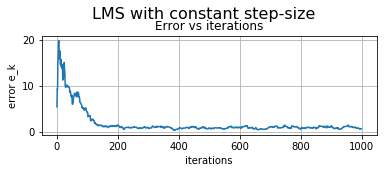

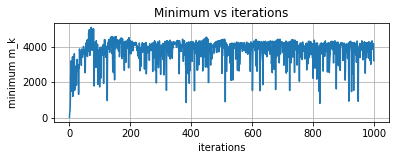

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-9]]


In [35]:
(k_iterations, ck) = lms_constant_step_size(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

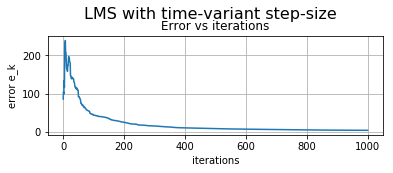

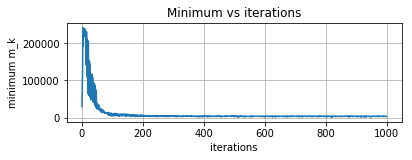

Aproximacion de los coeficientes:
[[11]
 [ 3]
 [ 7]
 [-6]
 [ 4]
 [ 0]
 [ 6]
 [-4]
 [-5]
 [-9]]


In [36]:
(k_iterations, ck) = lms_time_variant_step_size(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

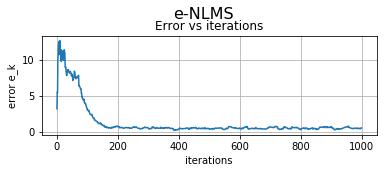

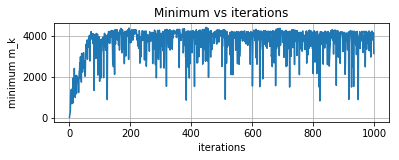

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-9]]


In [37]:
(k_iterations, ck) = e_nlms(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

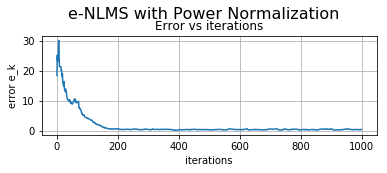

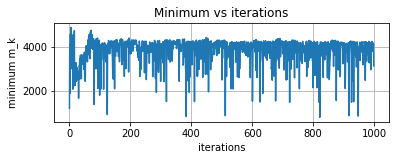

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-9]]


In [38]:
(k_iterations, ck) = e_nlms_power_norm(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

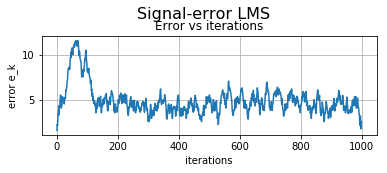

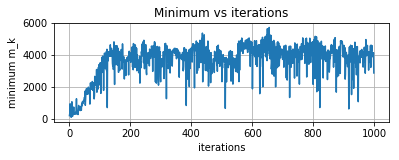

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 6]
 [-8]
 [ 3]
 [ 1]
 [ 6]
 [-4]
 [-6]
 [-9]]


In [39]:
(k_iterations, ck) = signal_error_lms(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

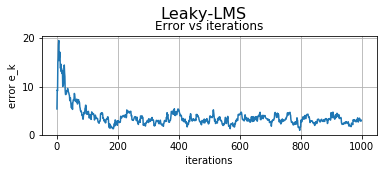

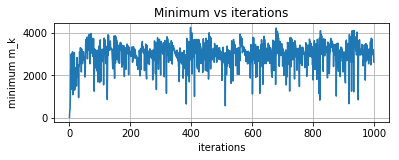

Aproximacion de los coeficientes:
[[ 9]
 [ 4]
 [ 7]
 [-8]
 [ 2]
 [ 1]
 [ 4]
 [-5]
 [-6]
 [-8]]


In [40]:
(k_iterations, ck) = leaky_lms(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

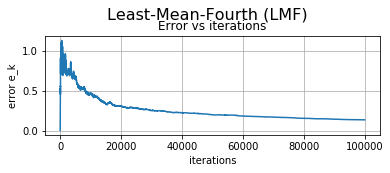

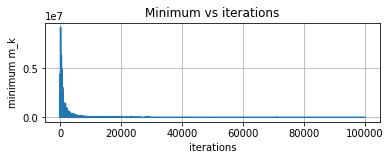

Aproximacion de los coeficientes:
[[ 9]
 [ 3]
 [ 7]
 [-7]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-8]]


In [41]:
(k_iterations, ck) = lmf(d, U, c_k, tol, 100000)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

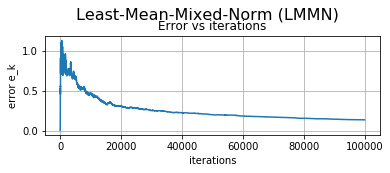

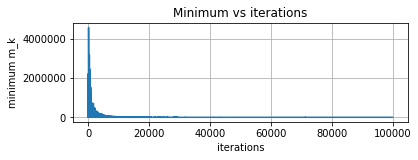

Aproximacion de los coeficientes:
[[ 9]
 [ 3]
 [ 7]
 [-7]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-8]]


In [16]:
(k_iterations, ck) = lmmn(d, U, c_k, tol, 100000)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

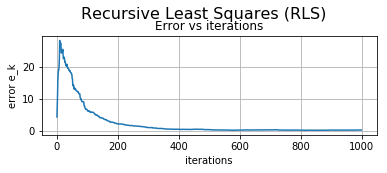

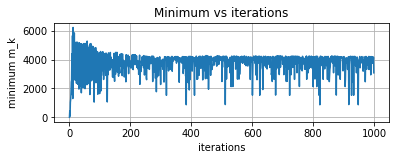

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 6]
 [-5]
 [-6]
 [-9]]


In [17]:
(k_iterations, ck) = rls(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

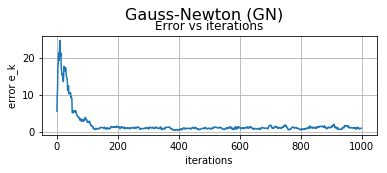

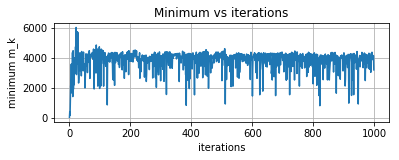

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 7]
 [-5]
 [-6]
 [-9]]


In [18]:
(k_iterations, ck) = gn(d, U, c_k, tol, iterMax)
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

**(b)** ¿Cuál de los métodos iterativos genera una mejor aproximación del vector $c$? Justifique su respuesta.

Es posible notar que el error tiende a cero para todos los algoritmos, como es esperado; mientras que el valor mínimo converge al valor $4000$. Este valor representa el valor mínimo que permite estimar el vector $c$ con el manor error posible.

Los algoritmos _Least-Mean-Mixed-Norm (LMMN)_ y _Least-Mean-Fourth (LMF)_, convergen mucho más lento que el resto de los algoritmos.

Los algoritmos _e-NLMS_, _e-NLMS with power-normalization_, _signal error LMS_ y _leaky LMS_ presentan resultados que convergen a los valores esperados. Sin embargo, también presentan gran cantidad de oscilaciones, dando inestabilidad a dichos resultados.

El algoritmo _Recursive Least Squares_ y _Gauss-Newton_ presentan resultados similares; sin embargo, el de _Gauss-Newton_ converge en menor cantidad de iteraciones. El algoritmo _LMS with constant step-size_ y _LMS with variable step-size_ también presentan resultados muy similares; sin embargo, las estimaciones iniciales son mas precisas en el algoritmo de paso constante.

Finalmente, al comparar el algoritmo _LMS with constant step-size_ y el algoritmo de _Gauss-Newton_, es posible notar que el algoritmo de Gauss-Newton tiene la capacidad de converger mas rápidamente, por lo que este último puede ser considerado como el que genera una mejor aproximación del vector $c$.

**(c)** Si se sabe de antemano que los coeficientes $c_0$, $\dots$, $c_9$ son números enteros, ¿cuál sería el valor exacto del vector $c$?. Justifique su respuesta.  

Utilizando la mejor apriximación que se obtiene por medio del algoritmo de Gauss-Newton (tal y como se justificó en la pregunta anterior), se grefica las evoluciones de las diferentes aproximaciones para cada uno de los 10 coeficientes.

De acuerdo a las gráfricas que se despliegan a continuación, los valores aproximados de los diferentes coeficientes son los siguientes:

In [19]:
print('Aproximacion de los coeficientes:')
print(ck[-1].round(0).astype(int))

Aproximacion de los coeficientes:
[[10]
 [ 3]
 [ 8]
 [-8]
 [ 3]
 [ 0]
 [ 7]
 [-5]
 [-6]
 [-9]]


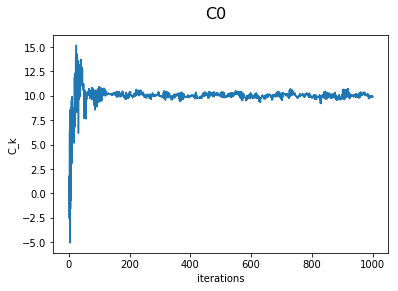

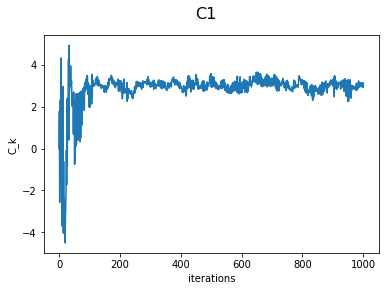

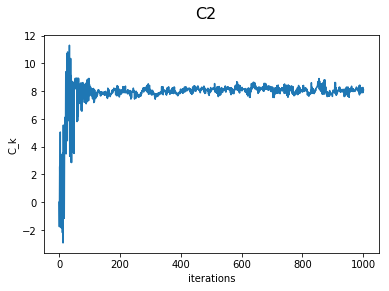

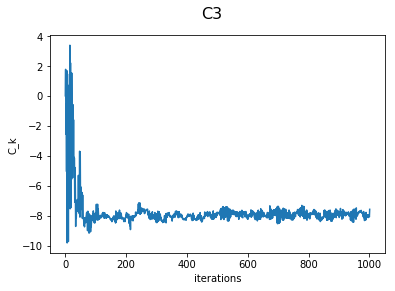

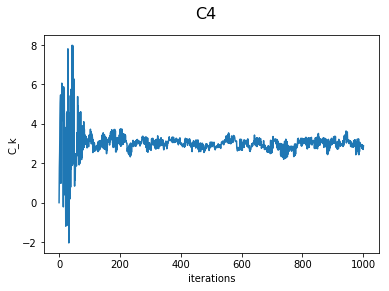

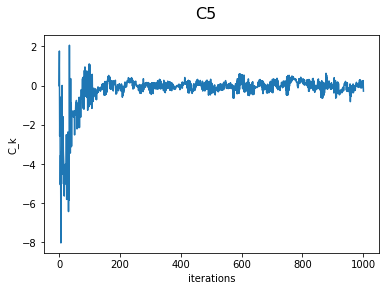

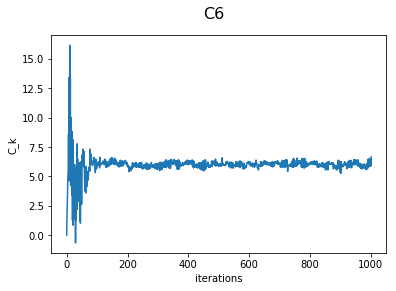

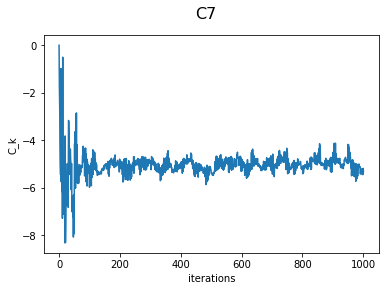

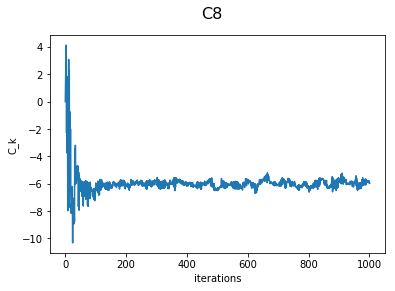

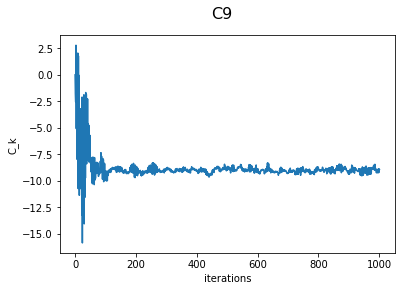

In [20]:
plot_aproximations(ck)

**Nota:** La justificación de las preguntas **(b)** y **(c)** se puede realizar utilizando las gráficas generadas en cada una de las funciones.